# Load financial data

In [93]:
import pandas as pd
import numpy as np
# data for Eurex futures are in this store
store = pd.HDFStore('/data/data/QH/L1.h5', 'r')
# do estimation using one month of data
asset = 'xFGBL'
#asset = 'xFDAX'
days = pd.bdate_range(start='20140101', end='20140601')
# we examine trades between multilpe components %%bashed on volume buckets:
bins = (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,np.inf)

In [94]:
def PriceUp(df):
    return (df.PriceMove > 0).values

def PriceDown(df):
    return (df.PriceMove < 0).values

def MarketOrdersAsk(df):
    return (df.PriceMove == 0).values * (df.OrderType == 0).values * (df.Side == 1).values

def MarketOrdersBid(df):
    return (df.PriceMove == 0).values * (df.OrderType == 0).values * (df.Side == -1).values  

def LimitAsk(df):
    return (df.PriceMove == 0).values * (df.OrderType == 1).values * (df.Side == 1).values

def LimitBid(df):
    return (df.PriceMove == 0).values * (df.OrderType == 1).values * (df.Side == -1).values

def CancelAsk(df):
    return (df.PriceMove == 0).values * (df.OrderType == -1).values * (df.Side == 1).values

def CancelBid(df):
    return (df.PriceMove == 0).values * (df.OrderType == -1).values * (df.Side == -1).values


def GetOrderBookEvents(df):
    """ Given df representing one day of data, returns list of array representing
        order book events for mid-price moves (ask/bid), number of market orders 
        (ask/bid), number of limit order (ask/bid), number of cancel orders (ask/bid)"""
    
    out = []
    out += [np.copy(df.loc[PriceUp(df), "Time"].values)]
    out += [np.copy(df.loc[PriceDown(df), "Time"].values)]
    out += [np.copy(df.loc[MarketOrdersAsk(df), "Time"].values)]
    out += [np.copy(df.loc[MarketOrdersBid(df), "Time"].values)]
    out += [np.copy(df.loc[LimitAsk(df), "Time"].values)]
    out += [np.copy(df.loc[LimitBid(df), "Time"].values)]
    out += [np.copy(df.loc[CancelAsk(df), "Time"].values)]
    out += [np.copy(df.loc[CancelBid(df), "Time"].values)]
    return out

def GetComponents(df, vol_bins):
    """ Given df representing one day of data, returns list of array representing 
        trades time for each volume component"""
    
    mask = lambda x, y: (df.OrderType==0).values * (np.abs(df.Volume.values)>x) * (np.abs(df.Volume.values)<=y)
    out = []
    for ii in range(len(vol_bins)-1): 
        out += [np.copy(df.loc[mask(vol_bins[ii], vol_bins[ii+1]), 'Time'].values)]
    return out

In [95]:
big_data = []
for d in days:
    try:
        df = store.get('%s/%s' %(asset, d.strftime('%Y%m%d')))
    except KeyError:
        continue
    data = GetComponents(df, bins)
    #data = GetOrderBookEvents(df)
    big_data.append(data)

In [96]:
len(big_data)

103

# Fit (=> compute the cumulants)

In [97]:
import whma.cumulants as cu
half_width = 10.
cumul = cu.Cumulants(big_data, half_width=half_width)
cumul.compute_cumulants(half_width,method="parallel_by_day")

L is computed
C is computed


# Solve (=> minimize the objective function via ADMM)

In [98]:
from whma.solver import admm
from whma.prox import prox_l1, prox_sq_frob, prox_l2, prox_zero, prox_nuclear
G = admm(cumul, prox_l1, rho=1., maxiter=10000)

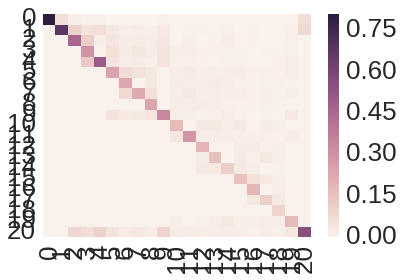

In [99]:
%matplotlib inline
import seaborn as sns
sns.heatmap(G)

# Nice heatmap

In [100]:
from pylab import rcParams
from pylab import Rectangle
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

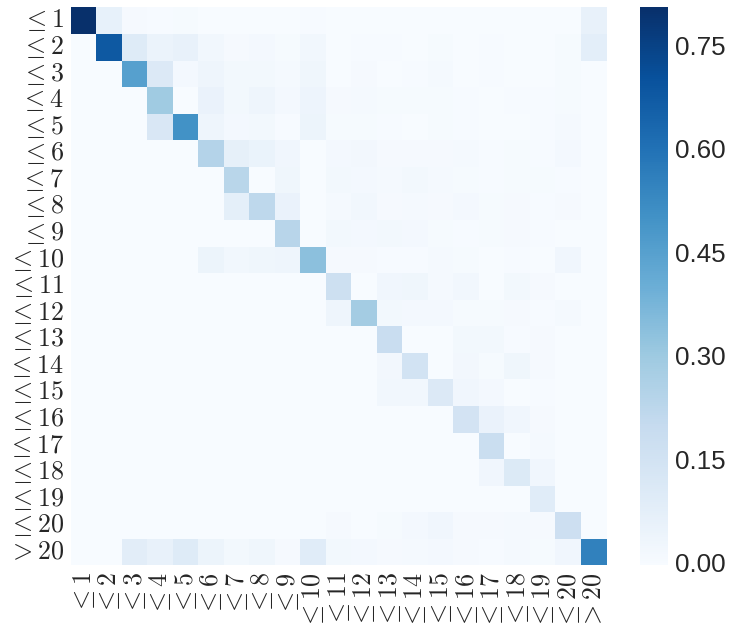

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,10)
plt.rcParams['xtick.labelsize'] = 26
plt.rcParams['ytick.labelsize'] = 26
dimensions = ["$\leq 1$","$\leq 2$","$\leq 3$","$\leq 4$","$\leq 5$",
              "$\leq 6$","$\leq 7$","$\leq 8$","$\leq 9$","$\leq 10$",
              "$\leq 11$","$\leq 12$","$\leq 13$","$\leq 14$","$\leq 15$",
              "$\leq 16$","$\leq 17$","$\leq 18$","$\leq 19$","$\leq 20$",
              "$ > 20$"]
#cmap = sns.cubehelix_palette(light=1, as_cmap=True)
#cmap = sns.diverging_palette(10, 220, sep=1, n=7, as_cmap=True)
sns_plot = sns.heatmap(G,cmap="Blues",xticklabels=dimensions,yticklabels=dimensions)
sns_plot.get_figure().savefig('bins21D.png')